# Imagify

# Choose Text

In [1]:
text_input = "Bright sun above the lake" #@param {type:"string"}


#Execution

# This one!

In [2]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 47.8 MB/s eta 0:00:07tcmalloc: large alloc 1147494400 bytes == 0x555d2436e000 @  0x7f42dc414615 0x555cea03e4cc 0x555cea11e47a 0x555cea0412ed 0x555cea132e1d 0x555cea0b4e99 0x555cea0af9ee 0x555cea042bda 0x555cea0b4d00 0x555cea0af9ee 0x555cea042bda 0x555cea0b1737 0x555cea133c66 0x555cea0b0daf 0x555cea133c66 0x555cea0b0daf 0x555cea133c66 0x555cea0b0daf 0x555cea043039 0x555cea086409 0x555cea041c52 0x555cea0b4c25 0x555cea0af9ee 0x555cea042bda 0x555cea0b1737 0x555cea0af9ee 0x555cea042bda 0x555cea0b0915 0x555cea042afa 0x555cea0b0c0d 0x555cea0af9ee
     |█████████████████████████████▏  | 1055.7 MB 1.7 MB/s eta 0:01:02tcmalloc: large alloc 1434370048 bytes == 0x555d689c4000 @  0x7f42dc414615 0x555cea03e4cc 0x555cea11e47a 0x555cea0412ed 0x555cea132e1d 0x555cea0b4e99 0x555cea0af9ee 0x555cea042bda 0x555cea0b4d00 0x555cea0af9ee 0x555cea042bda 0x555cea0b1737 0x555ce

# Top


In [3]:
# don't use half of these lol

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [4]:
# were you lucky today?

!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-83dd38c0-5fca-5f74-7f41-9acfaca38ecf)


# Perceptor

In [5]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch

clip.available_models()

import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

/content
Cloning into 'CLIP'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 185 (delta 7), reused 3 (delta 3), pack-reused 168
Receiving objects: 100% (185/185), 8.90 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/CLIP


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 118MiB/s]


# Params

In [6]:
# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape


# Define

In [7]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

In [8]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

!pip install git+https://github.com/openai/DALL-E.git


from dall_e import map_pixels, unmap_pixels, load_model
target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')


  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-fzuimb4n
  Running command git clone -q https://github.com/openai/DALL-E.git /tmp/pip-req-build-fzuimb4n
     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 21.5 MB 1.4 MB/s 
     |████████████████████████████████| 138 kB 49.6 MB/s 
     |████████████████████████████████| 1.9 MB 21.5 MB/s 
     |████████████████████████████████| 743 kB 29.8 MB/s 
     |████████████████████████████████| 127 kB 49.3 MB/s 
  Created wheel for DALL-E: filename=DALL_E-0.1-py3-none-any.whl size=6010 sha256=73f3238d066ed2c44e83ed20e70731ff3e3d97d99b2b1003277bb158f80e2681
  Stored in directory: /tmp/pip-ephem-wheel-cache-beesdqg1/wheels/4f/d2/6b/6b7aaca8942aea8c54dcfd507ec933e997a772377ae071f608
Successfully built DALL-E
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependenc

In [9]:
# enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", 'cpu')



# x = (torch.zeros(1, 3, 512, 512))


# z_logits = enc(x)
# z = torch.argmax(z_logits, axis=1)
# z = torch.nn.functional.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()


# Latent coordinate

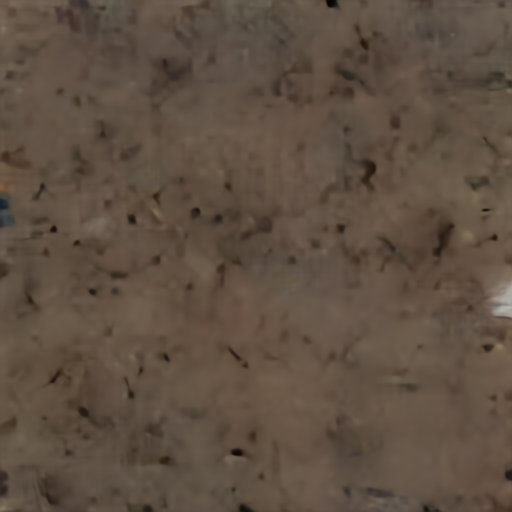

In [10]:

class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()

        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())



    def forward(self):

      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)

      return normu




lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0



tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))


# Train

In [ ]:
#@title Look for images below here { vertical-output: true, display-mode: "form" }



def checkin(loss):
  print('''
  ##########################################################
  ''',
        loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))

  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')

  into = nom(into)

  iii = perceptor.encode_image(into)


  llls = lats()
  lat_l = 0



  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 100 == 0:
    checkin(loss1)


itt = 0
for asatreat in range(10000):
  train(itt)
  itt+=1



## References



https://github.com/openai/DALL-E/ (Aditya Ramesh, Mikhail Pavlov, Gabriel Goh, Scott Gray, Chelsea Voss, Alec Radford, Mark Chen, Ilya Sutskever)

https://github.com/openai/CLIP (Alec Radford, \* Jong Wook Kim,\* Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal,
Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever)

\* equal contribution

Also, as a good launching point for future directions and to find more related work, see https://distill.pub/2017/feature-visualization/ by Chris Olah, Alexander Mordvintsev, Ludwig Schubert.



---

